# Inference of hierarchical logarctanh-normal model parameters

In [41]:
import arviz as az
import chi
import matplotlib.pyplot as plt
import numpy as np
import pints
import scipy.stats
import seaborn as sns
import xarray as xr
sns.set_theme()

The data-generating distribution is
$$
    \log \mathrm{arctanh}\, y \sim p(\cdot | \mu _{\mathrm{pop}}) =
    \int \mathrm{d}\mu \, \mathcal{N}(\log y | \mu, 1)\,
    \mathcal{N}(\mu | \mu _{\mathrm{pop}}, 1)
$$

Due to the conjugacy of Gaussian distributions, the hierarchical distribution
can be computed exactly to be

$$
    \log \mathrm{arctanh}\, y \sim \mathcal{N}(\cdot | \mu _{\mathrm{pop}}, 2).
$$

Together with
a Gaussian prior $\mu _{\mathrm{pop}} \sim \mathcal{N}(\cdot | \mu _0 = 0, \sigma _0^2 = 16)$, we
can also use the conjugacy to compute the posterior
distribution analytically
$$
    p(\mu _{\mathrm{pop}} | \mathcal{D}) =
        \mathcal{N}(\mu _{\mathrm{pop}} | \mu ', \sigma '^2 ),
$$
where
$$
    \mu' = \sigma '^2\frac{n\overline{\log\mathrm{arctanh}\, y}}{2},
    \quad
    \sigma '^2 = \frac{16}{1 + 8n}.
$$
Here, $n$ is the number of snapshot observations in the dataset
$\mathcal{D}=\{y_j^{\mathrm{obs}}\}$ and $\overline{\log\mathrm{arctanh} y}$ denotes the empirical mean,
$\overline{\log\mathrm{arctanh}\, y} = \sum _j \log\mathrm{arctanh}\, y_j^{\mathrm{obs}} / n$.

# Synthesise data

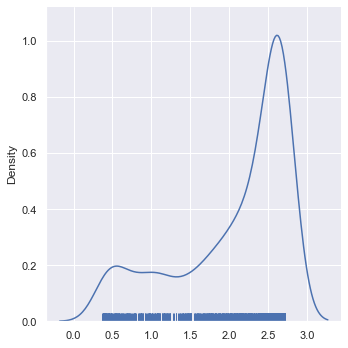

In [2]:
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean log, pop std. log, noise log
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
logarctanh_data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    logarctanh_data[ids] = np.random.normal(
        loc=mean, scale=true_parameters[2], size=n_samples_per_id)
data = np.exp(np.tanh(logarctanh_data))

sns.displot(data.flatten(), kind='kde', rug=True)
plt.show()

## Define log-likelihoods

1. Gaussian filter log-likelihood
2. Gaussian KDE filter log-likelihood
3. Lognormal filter log-likelihood
4. Lognormal KDE filter log-likelihood
5. t-distribution KDE filter log-likelihood
6. Data-centric Gaussian KDE filter log-likelihood

In [37]:
class GaussianFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._normal = chi.GaussianErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(np.tanh(mean_samples + sigma * epsilon))

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute log-likelihood
        score = np.sum(
            scipy.stats.norm(loc=pop_mu_hat, scale=pop_sigma_hat).logpdf(
                self._observations))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = \
            pop_sigma * measurements * (1 - log_measurements**2) \
            / self._n_samples
        dpop_mu_hat_depsilon = \
            sigma * measurements * (1 - log_measurements**2) / self._n_samples
        dpop_mu_hat_dpop_mu = np.mean(measurements * (1 - log_measurements**2))
        dpop_sigma_hat_deta = \
            pop_sigma * measurements * (1 - log_measurements**2) * \
            (measurements - pop_mu_hat) / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_depsilon = \
            sigma * measurements * (1 - log_measurements**2) \
            * (measurements - pop_mu_hat) / (self._n_samples - 1) \
            / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = \
            np.sum(
                (measurements * (1 - log_measurements**2)
                - dpop_mu_hat_dpop_mu) * (measurements - pop_mu_hat)
            ) / (self._n_samples - 1) / pop_sigma_hat

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu]), shape=(n_obs, 2*self._n_samples + 1))
        score, sens = self._normal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples:2*self._n_samples] \
            + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2*self._n_samples] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Log mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class GaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_samples) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        measurements = np.exp(np.tanh(mean_samples + sigma * epsilon))

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurements[np.newaxis, :] -
                self._observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/deta = exp(score) / sum(exp(scores)) * dscore / deta
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax \
                * (measurements * (1 - log_measurements**2))[np.newaxis, :],
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax \
                * (measurements * (1 - log_measurements**2))[np.newaxis, :],
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (measurements[np.newaxis, :] -
                self._observations[:, np.newaxis]) *
                softmax
                * (measurements * (1 - log_measurements**2))[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Log mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class LognormalFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)
        self._lognormal = chi.LogNormalErrorModel()

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(log_measurements, ddof=1)

        # Compute log-likelihood
        n_obs = len(self._observations)
        score = self._lognormal.compute_log_likelihood(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            observations=self._observations)

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(log_measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = \
            pop_sigma * measurements * (1 - log_measurements**2) \
            / self._n_samples
        dpop_mu_hat_depsilon = \
            sigma * measurements * (1 - log_measurements**2) / self._n_samples
        dpop_mu_hat_dpop_mu = np.mean(measurements * (1 - log_measurements**2))
        dpop_sigma_hat_deta = \
            pop_sigma / pop_sigma_hat * (1 - log_measurements**2) * \
            (log_measurements - np.mean(log_measurements)) \
            / (self._n_samples - 1)
        dpop_sigma_hat_depsilon = \
            sigma * (1 - log_measurements**2) \
            * (log_measurements - np.mean(log_measurements)) \
            / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = \
            np.sum(
                (log_measurements - np.mean(log_measurements))
                * (1 - log_measurements**2 - np.mean(1 - log_measurements**2))
            ) / (self._n_samples - 1) / pop_sigma_hat

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu]), shape=(n_obs, 2*self._n_samples + 1))
        score, sens = self._lognormal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples:2*self._n_samples] \
            + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2*self._n_samples] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Log mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class LognormalKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=1000, kernel_scale=None):
        self._log_observations = np.log(observations.flatten())
        self._n_samples = int(n_samples)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = self._n_samples ** (-0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        score = np.sum(scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2, axis=1) - np.log(self._n_samples))

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[-1]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis])**2 \
            / self._kernel_scale**2 / 2
        score = np.sum(
            scipy.special.logsumexp(scores, axis=1) - np.log(self._n_samples))

        # Collect sensitivities
        # p = log mean exp scores
        # dp/deta = exp(score) / sum(exp(scores)) * dscore / deta
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        # dp/dpop_mean = exp(score) / sum(exp(scores)) * dscore / dpop_mean
        softmax = \
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]) / np.sum(
            np.exp(scores - np.max(scores, axis=1)[:, np.newaxis]),
            axis=1)[:, np.newaxis]

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            - pop_sigma / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax * (1 - log_measurements**2)[np.newaxis, :],
                axis=0)
        sensitivities[self._n_samples:2*self._n_samples] = \
            - sigma / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax * (1 - log_measurements**2)[np.newaxis, :],
                axis=0)
        sensitivities[2*self._n_samples] = \
            - 1 / self._kernel_scale**2 * np.sum(
                (log_measurements[np.newaxis, :] -
                self._log_observations[:, np.newaxis]) *
                softmax * (1 - log_measurements**2)[np.newaxis, :])

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return ['Log mean eta'] * self._n_samples + [
            'Epsilon'] * self._n_samples + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class TDistributionKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, n_samples=10):
        self._observations = np.array(observations).flatten()
        self._n_samples = int(n_samples)

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_var_hat = np.var(log_measurements, ddof=1)

        # Compute log-likelihood
        score = \
            np.sum(1 / np.pi
            / (1 + (pop_mu_hat - self._observations)**2 / pop_var_hat))

        if np.isnan(score):
            return -np.inf

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        eta = np.array(parameters[:self._n_samples])
        epsilon = np.array(parameters[self._n_samples:2*self._n_samples])
        pop_mu = parameters[2*self._n_samples]
        pop_sigma, sigma = [1, 1]

        # Compute measurements
        mean_samples = pop_mu + eta * pop_sigma
        log_measurements = np.tanh(mean_samples + sigma * epsilon)
        measurements = np.exp(log_measurements)

        # Estimate population mean and population std from samples
        pop_mu_hat = np.mean(measurements)
        pop_sigma_hat = np.std(log_measurements, ddof=1)

        # Compute sensitivities of pop_mu and pop_sigma to parameters
        dpop_mu_hat_deta = \
            pop_sigma * measurements * (1 - log_measurements**2) \
            / self._n_samples
        dpop_mu_hat_depsilon = \
            sigma * measurements * (1 - log_measurements**2) / self._n_samples
        dpop_mu_hat_dpop_mu = np.mean(measurements * (1 - log_measurements**2))
        dpop_sigma_hat_deta = \
            pop_sigma / pop_sigma_hat * (1 - log_measurements**2) * \
            (log_measurements - np.mean(log_measurements)) \
            / (self._n_samples - 1)
        dpop_sigma_hat_depsilon = \
            sigma * (1 - log_measurements**2) \
            * (log_measurements - np.mean(log_measurements)) \
            / (self._n_samples - 1) / pop_sigma_hat
        dpop_sigma_hat_dpop_mu = \
            np.sum(
                (log_measurements - np.mean(log_measurements))
                * (1 - log_measurements**2 - np.mean(1 - log_measurements**2))
            ) / (self._n_samples - 1) / pop_sigma_hat

        # Estimate likelihood with Gaussian KDE and compute associated
        # sensitivities
        n_obs = len(self._observations)
        model_sensitivities = np.broadcast_to(np.hstack([
            dpop_mu_hat_deta,
            dpop_mu_hat_depsilon,
            dpop_mu_hat_dpop_mu]), shape=(n_obs, 2*self._n_samples + 1))
        score, sens = self._lognormal.compute_sensitivities(
            parameters=[pop_sigma_hat],
            model_output=np.array([pop_mu_hat] * n_obs),
            model_sensitivities=model_sensitivities,
            observations=self._observations)

        # Compute final sensitivities
        # dp/deta =
        #   dp/dpop_mu_hat * dpop_mu_hat/deta +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/deta
        # dp/depsilon =
        #   dp/dpop_mu_hat * dpop_mu_hat/depsilon +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/depsilon
        # dp/dpop_mu =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_mu +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_mu
        # dp/dpop_sigma =
        #   dp/dpop_mu_hat * dpop_mu_hat/dpop_sigma +
        #   dp/dpop_sigma_hat * dpop_sigma_hat/dpop_sigma
        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[:self._n_samples] = \
            sens[:self._n_samples] + sens[-1] * dpop_sigma_hat_deta
        sensitivities[self._n_samples:2*self._n_samples] = \
            sens[self._n_samples:2*self._n_samples] \
            + sens[-1] * dpop_sigma_hat_depsilon
        sensitivities[2*self._n_samples] = \
            sens[2*self._n_samples] + sens[-1] * dpop_sigma_hat_dpop_mu

        return score, sensitivities

    def n_parameters(self):
        return 2 * self._n_samples + 1

    def get_parameter_names(self):
        return [
            'Log mean eta' for _ in range(self._n_samples)] + [
            'Epsilon' for _ in range(self._n_samples)] + ['Pop. log mean']

    def get_id(self):
        return ['ID %d' % _id for _id in range(self._n_samples)] * 2 + [None]


class DataCentricGaussianKDEFilterLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations, kernel_scale=None):
        self._observations = observations.flatten()
        self._n_obs = len(self._observations)
        self._epsilon_prior = pints.GaussianLogPrior(0, 1)

        # Set kernel scale
        # (If None or non-positive use Scott's rule of thumb (like scipy))
        if (not kernel_scale) or (kernel_scale <=0):
            kernel_scale = \
                np.std(observations, ddof=1) \
                * (4 / 3 / self._n_obs) ** (0.2)
        self._kernel_scale = kernel_scale

    def __call__(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu, epsilon = parameters
        sigma = 1
        measurement = np.exp(np.tanh(mu + sigma * epsilon))

        # Estimate log-likelihood as the mean across kdes
        score = scipy.special.logsumexp(
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) - (
                measurement - self._observations)**2 \
            / self._kernel_scale**2 / 2) - np.log(self._n_obs)

        # Add noise prior contribution
        # (n_obs fold to account for averaging of population kernel over
        # n_obs observations)
        score += self._n_obs * self._epsilon_prior([epsilon])

        return score

    def evaluateS1(self, parameters):
        # Eta are inter-individual fluctuations and epsilon are measurement
        # fluctuations
        mu, epsilon = parameters
        sigma = 1
        measurement = np.exp(np.tanh(mu + sigma * epsilon))

        # Estimate log-likelihood as the mean across kdes
        scores = \
            - np.log(2 * np.pi) / 2 - np.log(self._kernel_scale) \
            - (measurement - self._observations)**2 \
            / self._kernel_scale**2 / 2
        score = scipy.special.logsumexp(scores) - np.log(self._n_obs)

        # Add noise prior contribution
        # (n_obs fold to account for averaging of population kernel over
        # n_obs observations)
        s, sens = self._n_obs * self._epsilon_prior.evaluateS1([epsilon])
        score += s

        # Collect sensitivities
        # p = log mean exp scores
        # dp/dmu = exp(score) / sum(exp(scores)) * dscore / dmean
        # dp/depsilon = exp(score) / sum(exp(scores)) * dscore / depsilon
        softmax = \
            np.exp(scores - np.max(scores)) \
            / np.sum(np.exp(scores - np.max(scores)))

        sensitivities = np.zeros(shape=self.n_parameters())
        sensitivities[0] = \
            - 1 / self._kernel_scale**2 \
            * np.sum(
                (measurement - self._observations) * softmax * measurement
                * (1 - measurement**2))
        sensitivities[1] = \
            - sigma / self._kernel_scale**2 \
            * np.sum(
                (measurement - self._observations) * softmax * measurement
                * (1 - measurement**2)) + sens[0]

        return score, sensitivities

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mu', 'Epsilon']

    def get_id(self):
        return [None] * 2

## Inference

### 1. Gaussian filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     17     0.5      1        0:00.0
1     18     0.25     1        0:00.0
2     19     0.25     1        0:00.0
3     146    0.5      64       0:00.1


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:59: RuntimeWarning: invalid value encountered in true_divide
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: invalid value encountered in true_divide
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in double_scalars


20    517    0.893    21       0:00.3
40    5719   0.794    248      0:02.9
60    8921   0.79     153      0:04.3
80    12421  0.767    167      0:05.9
100   15247  0.751    135      0:07.2
120   18235  0.715    143      0:08.6
140   21799  0.797    170      0:10.2
160   23850  0.691585 98       0:11.2
180   26516  0.785    127      0:12.3
200   29320  0.723    134      0:13.6
220   32077  0.764848 132      0:14.8
240   35065  0.754    143      0:16.3
260   36838  0.755    85       0:17.1
280   39188  0.735    112      0:18.2
300   41952  0.779    132      0:19.4
320   43988  0.752    97       0:20.3
340   45782  0.738    86       0:21.1
360   47660  0.772    90       0:22.0
380   49171  0.76     72       0:22.7
400   51423  0.763    108      0:23.7
420   52863  0.735    69       0:24.3
440   54859  0.777013 96       0:25.2
460   56555  0.701    81       0:26.0
480   58871  0.749    111      0:27.0
500   61859  0.772    143      0:28.5
520   64335  0.917    118      0:29.7
540   66875 

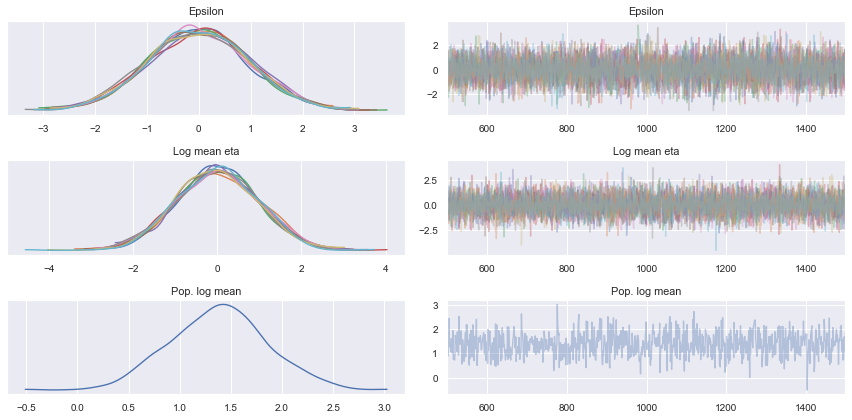

In [30]:
n_samples = 10
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_10_posterior_samples.sel(draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     8      0.5      1        0:00.0
1     9      0.25     1        0:00.0
2     10     0.25     1        0:00.0
3     11     0.25     1        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    1173   0.835    65       0:01.6
40    3493   0.762    111      0:04.6
60    5705   0.754    106      0:07.6
80    7352   0.776    79       0:09.7
100   9497   0.77     102      0:12.5
120   10666  0.72     56       0:14.0
140   11414  0.758    36       0:14.9
160   12159  0.712    36       0:15.9
180   13195  0.732    50       0:17.2
200   14103  0.792    44       0:18.4
220   14739  0.731    31       0:19.3
240   15391  0.742    32       0:20.1
260   16132  0.723    36       0:21.3
280   17008  0.773    42       0:22.7
300   17772  0.761    37       0:23.8
320   18360  0.755    28       0:24.9
340   18932  0.77     28       0:25.8
360   19552  0.731    30       0:26.8
380   20092  0.775    26       0:27.6
400   20568  0.754    23       0:28.3
420   21124  0.756    27       0:29.0
440   21616  0.771    24       0:29.7
460   22305  0.703    33       0:30.5
480   23341  0.748    50       0:31.9
500   24217  0.73     42       0:33.2
520   24837  0.897    30       0:34.2
540   25457 

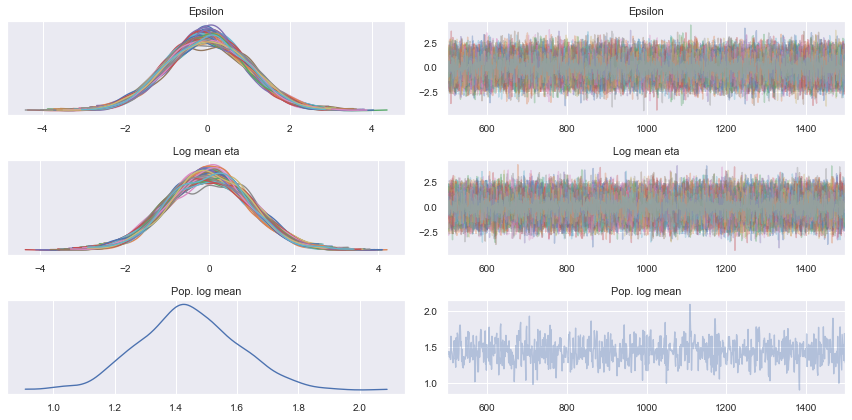

In [31]:
n_samples = 100
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


Iter. Eval. Accept.   Steps. Time m:s
0     68     0.5      32       0:00.9
1     69     0.25     1        0:00.9
2     70     0.25     1        0:00.9
3     76     0.214    3        0:01.0
20    2442   0.788    132      0:29.5
40    4976   0.775    121      0:59.6
60    6772   0.774    86       1:19.7
80    8845   0.764889 99       1:43.8
100   10666  0.759    87       2:04.4
120   11102  0.708    21       2:09.6
140   11642  0.764    26       2:16.0
160   12064  0.708    20       2:21.0
180   12572  0.742    25       2:27.0
200   13080  0.761    25       2:33.6
220   13540  0.760268 22       2:39.7
240   13920  0.767    19       2:44.5
260   14280  0.73     18       2:49.1
280   14756  0.746    23       2:56.8
300   15128  0.746    18       3:05.6
320   15564  0.748    21       3:13.0
340   15944  0.763    19       3:17.5
360   16324  0.768    19       3:22.3
380   16720  0.744521 19       3:26.8
400   17100  0.765    19       3:36.1
420   17480  0.755    19       3:45.2
440   17892 

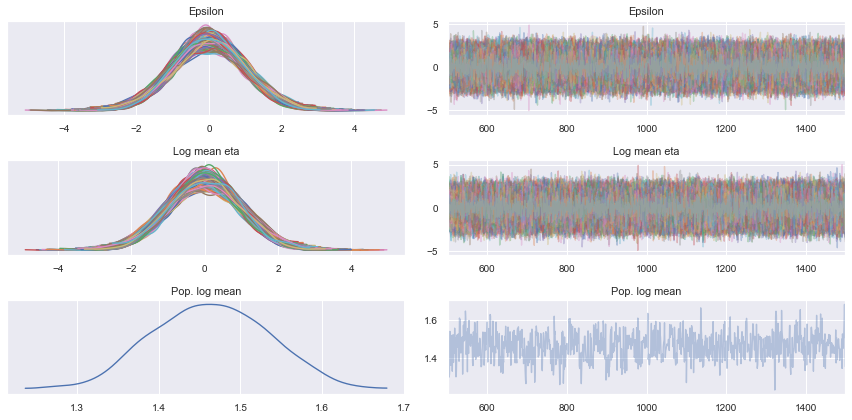

In [32]:
n_samples = 1000
log_likelihood = GaussianFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [33]:
gaussian_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_gaussian_filter_1000.nc')

### 2. Gaussian KDE filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     4      0.5      1        0:00.0
1     5      0.25     1        0:00.0
2     6      0.25     1        0:00.0
3     9      0.375    2        0:00.0
20    4241   0.746    236      0:03.9
40    7675   0.748952 164      0:06.8
60    10880  0.775    153      0:09.6
80    13271  0.761    114      0:11.7
100   15709  0.761    116      0:13.8
120   17864  0.697    103      0:15.6
140   21004  0.784    150      0:18.2
160   23004  0.688    96       0:19.9
180   26564  0.764    170      0:23.1
200   28976  0.753    115      0:25.3
220   31475  0.744    119      0:27.5
240   34377  0.788    139      0:30.1
260   36246  0.703    89       0:31.7
280   38969  0.746    130      0:33.9
300   41147  0.753872 104      0:35.9
320   43367  0.75926  106      0:38.2
340   45480  0.767    101      0:40.7
360   47318  0.727    88       0:42.6
380   49594  0.76     109      0:45.2
400   51778  0.764

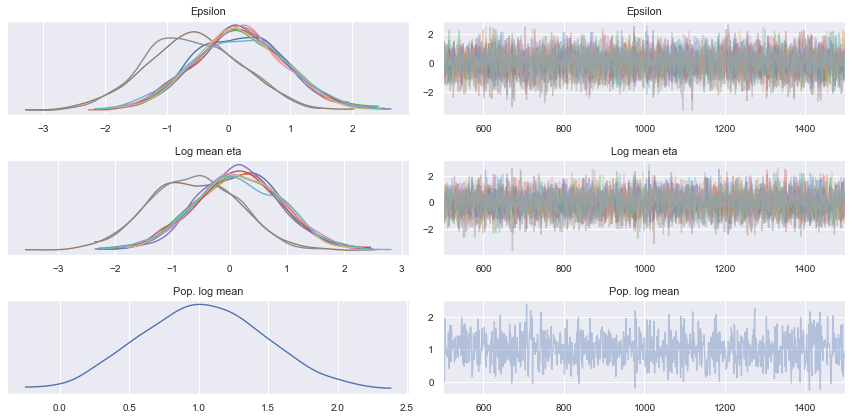

In [22]:
n_samples = 10
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.1
2     7      0.25     1        0:00.1
3     10     0.125    2        0:00.1
20    3087   0.771    171      0:13.3
40    5764   0.759    128      0:25.7
60    7793   0.751    97       0:33.1
80    9949   0.756    103      0:41.8
100   11633  0.749152 80       0:49.8
120   12688  0.701    51       0:54.3
140   14140  0.777    70       0:59.5
160   15231  0.716    52       1:03.3
180   16683  0.756    70       1:08.4
200   18103  0.749    68       1:13.3
220   19267  0.742    56       1:17.3
240   20303  0.769    50       1:21.0
260   21220  0.712    44       1:24.2
280   22352  0.777    54       1:28.4
300   23388  0.746    50       1:32.4
320   24392  0.753    48       1:36.0
340   25236  0.776039 41       1:39.1
360   26176  0.734    45       1:42.6
380   27020  0.773    41       1:45.5
400   27832  0.747

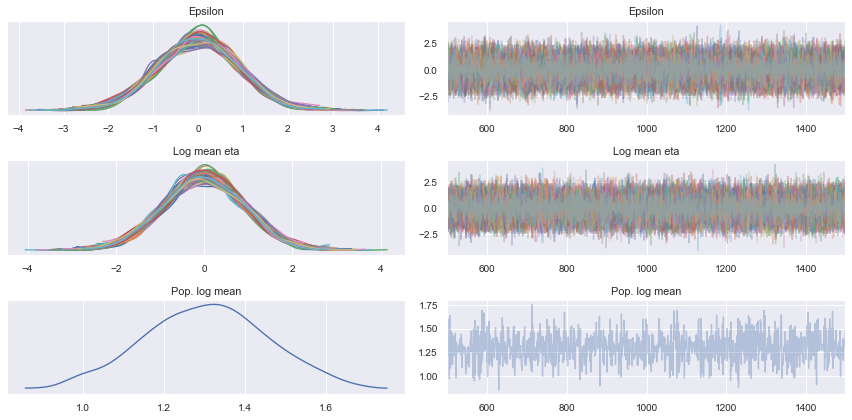

In [23]:
n_samples = 100
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     514    0.367    256      0:24.6
1     517    0.125    2        0:24.8
2     644    0.498884 64       0:31.5
3     707    0.354    32       0:35.1
20    2810   0.747379 117      2:14.6
40    5030   0.778399 106      3:50.7
60    7506   0.762456 118      5:42.8
80    9342   0.759    88       7:04.8
100   11214  0.751    89       8:29.0
120   12610  0.724    67       9:32.8
140   13774  0.764    56      10:27.7
160   15143  0.695    65      11:33.1
180   16755  0.767767 77      12:50.8
200   18079  0.757    64      13:51.4
220   19083  0.749    48      14:36.3
240   20151  0.755    51      15:27.0
260   21211  0.735    51      16:18.6
280   22375  0.739    56      17:12.7
300   23731  0.76613  65      18:15.2
320   24735  0.736    48      19:00.4
340   25835  0.791    53      19:48.4
360   26775  0.752    45      20:29.5
380   27779  0.748    48      21:14.5
400   28847  0.751

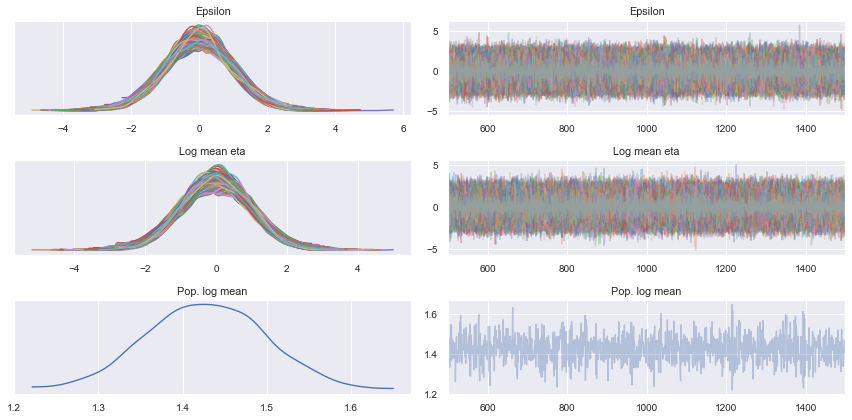

In [44]:
n_samples = 1000
log_likelihood = GaussianKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
gaussian_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    gaussian_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [45]:
gaussian_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_gaussian_kde_filter_1000.nc')

In [42]:
gaussian_kde_filter_1000_posterior_samples = xr.load_dataset(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_gaussian_kde_filter_1000.nc')

### 3. Lognormal filter likelihood

10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     11     0.5      2        0:00.0
1     12     0.25     1        0:00.0
2     13     0.25     1        0:00.0
3     14     0.25     1        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:282: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:282: RuntimeWarning: invalid value encountered in multiply
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:286: RuntimeWarning: invalid value encountered in true_divide
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:291: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/

20    2099   0.825    116      0:01.5
40    6692   0.754    219      0:04.6
60    9858   0.788    151      0:06.3
80    13518  0.764    175      0:08.7
100   17055  0.718    169      0:10.8
120   22644  0.745    267      0:14.0
140   26558  0.747    187      0:16.8
160   29655  0.713    148      0:18.3
180   32338  0.79314  128      0:19.9
200   35888  0.73     170      0:21.7
220   39352  0.764687 165      0:23.5
240   41922  0.762    123      0:24.8
260   44943  0.694    144      0:26.4
280   48839  0.758    186      0:28.4
300   52953  0.759    196      0:30.5
320   56197  0.771    155      0:32.0
340   59545  0.754    160      0:33.6
360   62194  0.747    127      0:34.9
380   65946  0.761    179      0:36.9
400   68836  0.761    138      0:38.3
420   71872  0.747    145      0:39.8
440   75032  0.757    151      0:41.3
460   77976  0.699    140      0:43.2
480   82052  0.762    195      0:46.1
500   85198  0.737    150      0:48.2
520   88122  0.92     140      0:49.8
540   91046 

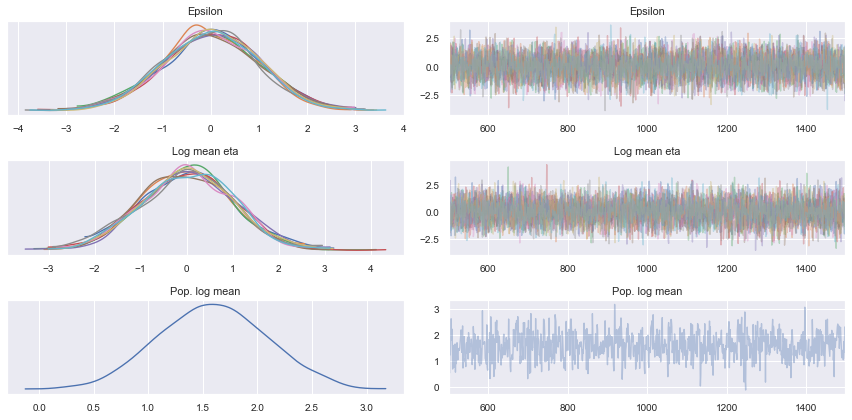

In [21]:
n_samples = 10
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     8      0.5      2        0:00.0
1     9      0.25     1        0:00.0
2     10     0.25     1        0:00.0
3     17     0.125    4        0:00.0


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:157: RuntimeWarning: overflow encountered in exp
  p = min(1, np.exp(other_state.n - self.n))


20    4621   0.82     256      0:06.6
40    7693   0.764    147      0:11.4
60    10168  0.76042  118      0:15.1
80    12013  0.734702 88       0:17.9
100   14106  0.754    100      0:21.3
120   15226  0.745    54       0:22.9
140   16326  0.741    53       0:24.4
160   17512  0.716    57       0:26.2
180   18644  0.774    54       0:27.9
200   19808  0.763    56       0:29.6
220   20708  0.726    43       0:30.8
240   21659  0.76     46       0:32.3
260   22738  0.769    52       0:33.8
280   24094  0.729658 65       0:35.8
300   25169  0.772    52       0:37.3
320   26045  0.777    42       0:38.5
340   26969  0.736031 44       0:39.9
360   27941  0.773    47       0:41.2
380   28689  0.758    36       0:42.2
400   29437  0.749    36       0:43.5
420   30249  0.772    39       0:44.6
440   30965  0.741    35       0:45.7
460   31753  0.704    38       0:46.8
480   32802  0.757    50       0:48.3
500   33758  0.786    46       0:49.6
520   34378  0.894    30       0:50.6
540   34998 

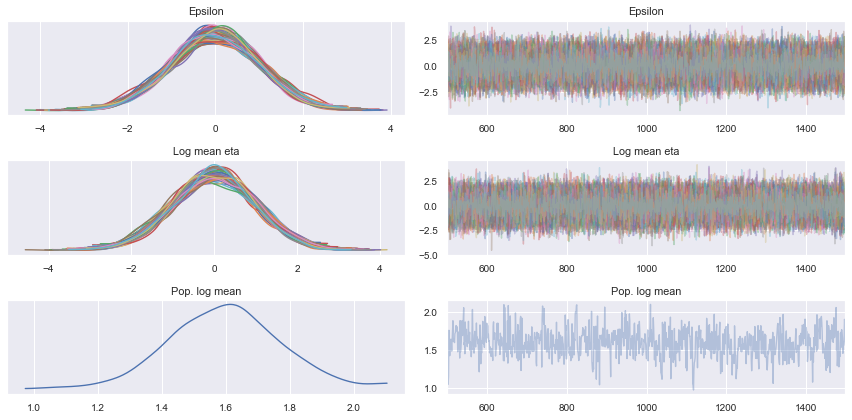

In [58]:
n_samples = 100
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     17     0.5      4        0:00.2


/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:280: RuntimeWarning: divide by zero encountered in double_scalars
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:280: RuntimeWarning: invalid value encountered in multiply
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:284: RuntimeWarning: invalid value encountered in true_divide
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/ipykernel_launcher.py:289: RuntimeWarning: invalid value encountered in double_scalars
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/_nuts.py:258: RuntimeWarning: overflow encountered in exp
  alpha_dash = min(1.0, np.exp(comparison))
/Users/david/Workspace/sabs-r3/population-kde-inference/venv/lib/python3.7/site-packages/pints/_mcmc/

1     18     0.25     1        0:00.2
2     19     0.25     1        0:00.2
3     26     0.5      4        0:00.3
20    2219   0.831    122      0:26.5
40    4766   0.773    122      0:55.4
60    7151   0.757    114      1:22.5
80    9907   0.776    132      1:53.9
100   12287  0.764    114      2:21.1
120   12757  0.744    23       2:26.5
140   13297  0.746    26       2:32.8
160   13654  0.73     17       2:37.6
180   14146  0.752    24       2:44.5
200   14598  0.765    22       2:50.3
220   15058  0.75     22       2:55.8
240   15422  0.755    18       3:00.4
260   15850  0.695    21       3:05.5
280   16294  0.76     22       3:12.0
300   16706  0.755    20       3:17.2
320   17174  0.757    23       3:23.1
340   17602  0.748    21       3:28.6
360   18038  0.755    21       3:34.0
380   18466  0.753    21       3:39.3
400   18894  0.778    21       3:44.5
420   19226  0.729    16       3:48.6
440   19670  0.79     22       3:54.1
460   20003  0.706    16       3:58.3
480   20479 

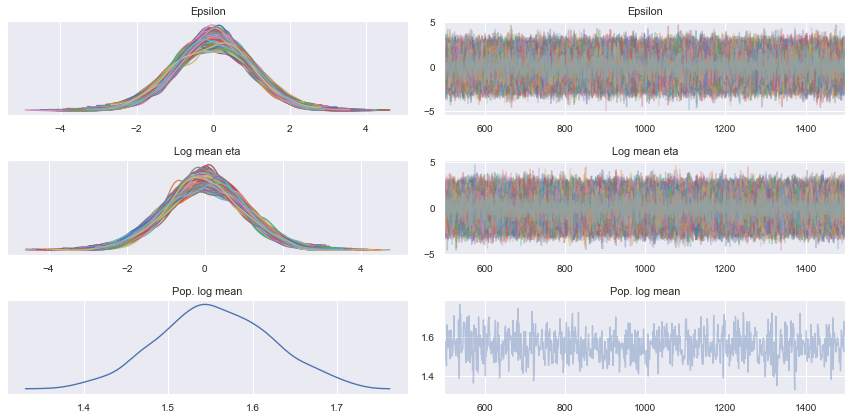

In [61]:
n_samples = 1000
log_likelihood = LognormalFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [62]:
lognormal_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_lognormal_filter_1000.nc')

### 4. Lognormal KDE filter likelilhood

In [68]:
epsilon = 0.00001
n_parameters = log_likelihood.n_parameters()
parameters = controller._initial_params[0, 0]
ref_sens = []
for index in range(n_parameters):
    # Construct parameter grid
    low = parameters.copy()
    low[index] -= epsilon
    high = parameters.copy()
    high[index] += epsilon

    # Compute reference using numpy.gradient
    sens = np.gradient(
        [
            log_likelihood(low),
            log_likelihood(parameters),
            log_likelihood(high)],
        (epsilon))
    ref_sens.append(sens[1])

# Compute sensitivities with hierarchical model
score, sens = log_likelihood.evaluateS1(parameters)

print(score)
print(log_likelihood(parameters))
for ids, s in enumerate(sens):
    if np.abs(s - ref_sens[ids]) > np.abs(epsilon * s):
        print('Param: ', ids)
        print('FD sens: ', ref_sens[ids])
        print('Model sens: ', s)
        break

-913.7670807449289
-913.7670807449289


10 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     11     0.156    4        0:00.0
1     15     0.201    2        0:00.0
2     22     0.25     4        0:00.0
3     53     0.455    16       0:00.1
20    2816   0.756    154      0:02.7
40    5636   0.743    135      0:05.2
60    8120   0.748    119      0:07.5
80    10824  0.771    129      0:10.0
100   12622  0.715195 86       0:11.7
120   15307  0.699    128      0:14.0
140   18831  0.763    168      0:17.1
160   22013  0.702    152      0:20.0
180   23667  0.771    79       0:21.5
200   25663  0.737    96       0:23.2
220   27899  0.761    107      0:25.1
240   29623  0.776    83       0:26.8
260   31694  0.72     99       0:28.7
280   35172  0.741787 166      0:31.9
300   37500  0.769    111      0:34.0
320   39820  0.75     111      0:36.0
340   41846  0.763    97       0:37.7
360   43762  0.76     92       0:39.6
380   45508  0.752    84       0:41.1
400   46968  0.765

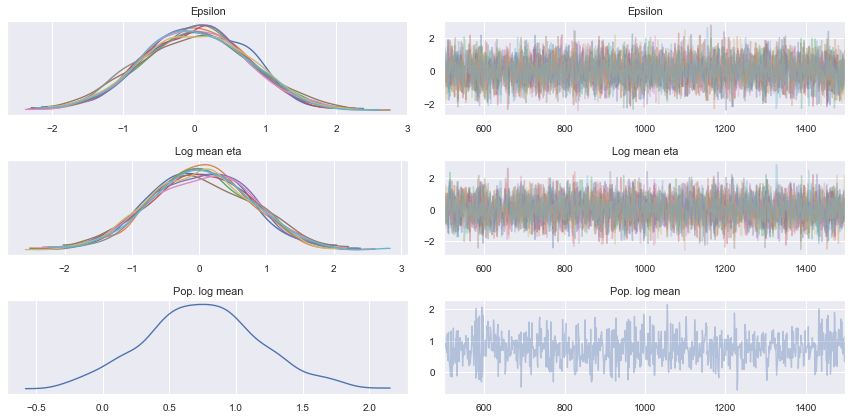

In [69]:
n_samples = 10
log_likelihood = LognormalKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_kde_filter_10_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_kde_filter_10_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

100 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     5      0.25     1        0:00.0
1     6      0.25     1        0:00.0
2     7      0.25     1        0:00.0
3     8      0.25     1        0:00.0
20    1431   0.754    80       0:06.0
40    3519   0.765    100      0:14.5
60    5643   0.734    102      0:23.1
80    7600   0.759    94       0:31.8
100   9615   0.741    96       0:41.3
120   10587  0.73     47       0:45.7
140   11511  0.767    44       0:49.8
160   12448  0.737    45       0:53.4
180   13292  0.76     41       0:56.6
200   14216  0.764    44       1:00.3
220   14980  0.747    37       1:03.3
240   15648  0.745793 32       1:05.8
260   16410  0.728    37       1:08.7
280   17318  0.737    44       1:12.5
300   18258  0.774    45       1:16.2
320   19118  0.757    41       1:19.8
340   19866  0.763    36       1:22.7
360   20614  0.748    36       1:25.6
380   21266  0.777    32       1:28.2
400   22014  0.751

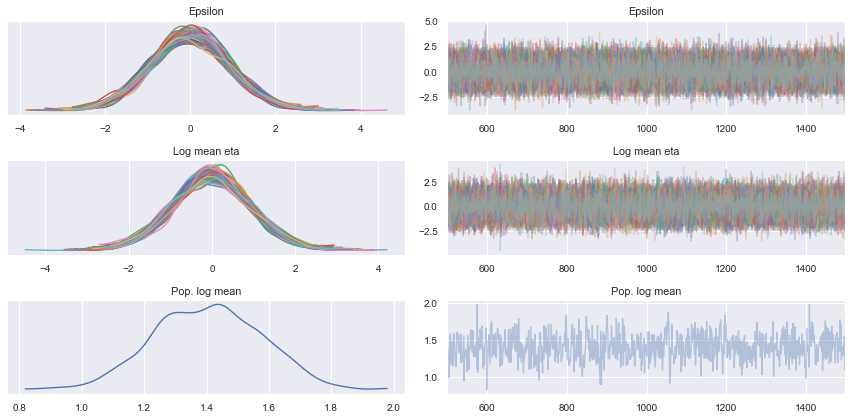

In [70]:
n_samples = 100
log_likelihood = LognormalKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_kde_filter_100_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_kde_filter_100_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

1000 samples

Using No-U-Turn MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Steps. Time m:s
0     20     0.353    8        0:01.0
1     21     0.25     1        0:01.0
2     23     0.167    1        0:01.1
3     34     0.0854   6        0:01.7
20    2040   0.763    112      1:35.3
40    4579   0.778    121      3:34.4
60    6582   0.757    96       5:08.2
80    8142   0.749    75       6:21.5
100   9549   0.725    67       7:27.3
120   10513  0.736    46       8:12.5
140   11293  0.763    38       8:49.0
160   11991  0.722    34       9:21.8
180   12851  0.755    41      10:01.8
200   13823  0.753    47      10:47.5
220   14571  0.77     36      11:22.8
240   15351  0.747231 38      11:59.5
260   16075  0.714    35      12:33.6
280   16919  0.758    41      13:13.1
300   17795  0.728    42      13:56.4
320   18495  0.791329 34      14:29.6
340   19179  0.752    33      15:01.7
360   19815  0.753    31      15:31.5
380   20563  0.757862 36      16:06.5
400   21215  0.741

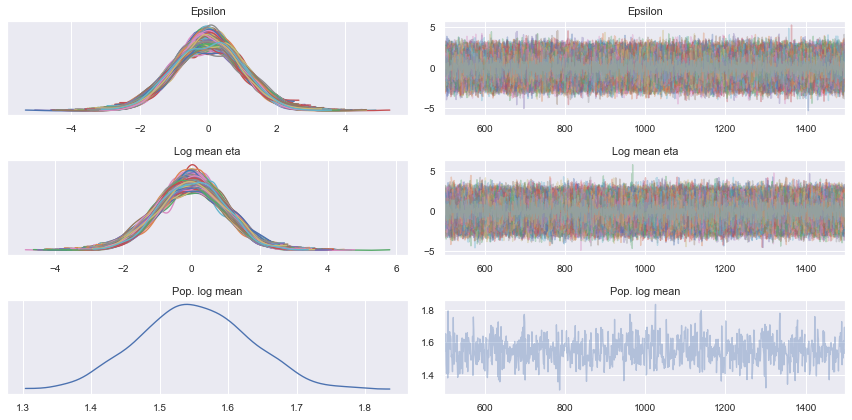

In [72]:
n_samples = 1000
log_likelihood = LognormalKDEFilterLogLikelihood(
    observations=data, n_samples=n_samples)
log_prior = pints.ComposedLogPrior(*[
    pints.GaussianLogPrior(0, 1)] * 2 * n_samples + [
    pints.GaussianLogPrior(mean=0, sd=4)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 1500
lognormal_kde_filter_1000_posterior_samples = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup=500
az.plot_trace(
    lognormal_kde_filter_1000_posterior_samples.sel(
        draw=slice(warmup, n_iterations)))
plt.tight_layout()

In [73]:
lognormal_kde_filter_1000_posterior_samples.to_netcdf(
    'derived_data/posteriors/'
    'hierarchical_logarctanhnormal_model_lognormal_kde_filter_1000.nc')

### 6. Data-centric Gaussian KDE likelihood

Using Haario adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0          0:00.0
2     3      0          0:00.0
3     4      0          0:00.0
20    21     0.286      0:00.0
40    41     0.463      0:00.0
60    61     0.492      0:00.0
80    81     0.444      0:00.0
100   101    0.386      0:00.0
120   121    0.347      0:00.1
140   141    0.305      0:00.1
160   161    0.28       0:00.1
180   181    0.265      0:00.1
Initial phase completed.
200   201    0.244      0:00.1
220   221    0.239819   0:00.1
240   241    0.266      0:00.1
260   261    0.28       0:00.1
280   281    0.316726   0:00.1
300   301    0.332      0:00.1
320   321    0.336      0:00.1
340   341    0.337      0:00.1
360   361    0.324      0:00.1
380   381    0.32021    0:00.1
400   401    0.319202   0:00.1
420   421    0.311      0:00.1
440   441    0.306      0:00.2
460   461    0.304      0:00.2
480   481    0.308  

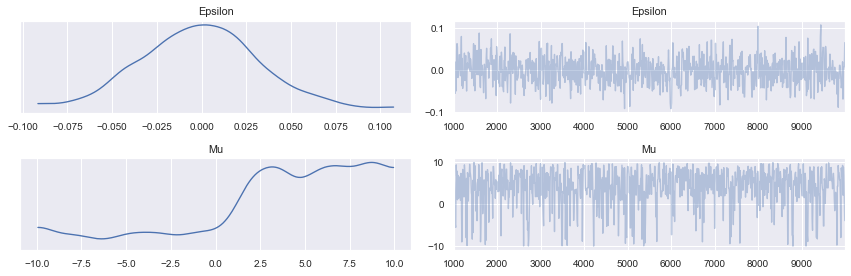

In [38]:
log_likelihood = DataCentricGaussianKDEFilterLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10),
    pints.UniformLogPrior(-10, 10)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
# controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 10000
data_centric_gaussian_kde_filter_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 1000
thinning = 10
az.plot_trace(
    data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()

## Comparison to analytic posterior

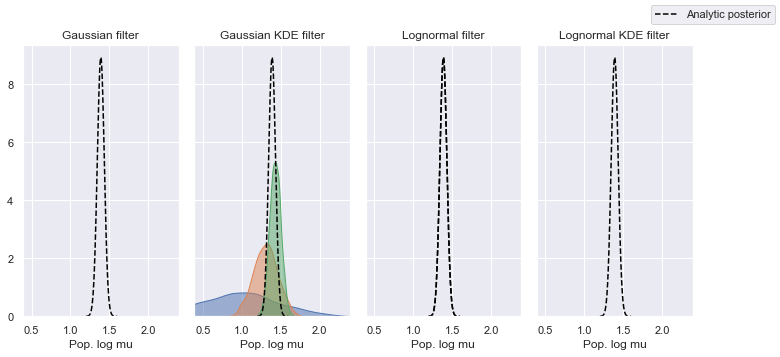

In [46]:
# Get true distribution
n = len(data)
posterior_var = 16 / (1 + n * 8)
posterior_mean = posterior_var * n * np.mean(logarctanh_data) / 2
mus = np.linspace(1.2, 1.6, num=200)
true_pdf = scipy.stats.norm(posterior_mean, np.sqrt(posterior_var)).pdf(mus)

# Create figure
fig, axes = plt.subplots(
    1, 4, figsize=(12, 5), sharey='row', sharex='row')
plt.subplots_adjust(wspace=0.1, hspace=0.3)
axes[0].set_xlim([posterior_mean - 1, posterior_mean + 1])
axes[0].set_xlabel('Pop. log mu')
axes[1].set_xlabel('Pop. log mu')
axes[2].set_xlabel('Pop. log mu')
axes[3].set_xlabel('Pop. log mu')
axes[0].set_title('Gaussian filter')
axes[1].set_title('Gaussian KDE filter')
axes[2].set_title('Lognormal filter')
axes[3].set_title('Lognormal KDE filter')
colors = sns.color_palette()

# # Plot Gaussian filter posteriors
# warmup = 1000
# thinning = 1
# mu_samples = gaussian_filter_10_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
#     palette=colors[0], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = gaussian_filter_100_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
#     palette=colors[1], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = gaussian_filter_1000_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[0],
#     palette=colors[2], legend=False)

# Plot Gaussian KDE filter posteriors
warmup = 1000
thinning = 1
mu_samples = gaussian_kde_filter_10_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[0], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_100_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

warmup = 500
thinning = 1
mu_samples = gaussian_kde_filter_1000_posterior_samples.sel(
    draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
sns.kdeplot(
    x=mu_samples,
    fill=True,
    common_norm=False, alpha=.5, linewidth=1, ax=axes[1],
    palette=colors[1], legend=False)

# # Plot lognormal filter posteriors
# warmup = 500
# thinning = 1
# mu_samples = lognormal_filter_10_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
#     palette=colors[0], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = lognormal_filter_100_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
#     palette=colors[1], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = lognormal_filter_1000_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[2],
#     palette=colors[1], legend=False)

# # Plot lognormal KDE filter posteriors
# warmup = 500
# thinning = 1
# mu_samples = lognormal_kde_filter_10_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
#     palette=colors[0], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = lognormal_kde_filter_100_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
#     palette=colors[0], legend=False)

# warmup = 500
# thinning = 1
# mu_samples = lognormal_kde_filter_1000_posterior_samples.sel(
#     draw=slice(warmup, n_iterations, thinning))['Pop. log mean'].values[0]
# sns.kdeplot(
#     x=mu_samples,
#     fill=True,
#     common_norm=False, alpha=.5, linewidth=1, ax=axes[3],
#     palette=colors[0], legend=False)

# # Plot true value
# axes[0].axvline(x=true_parameters[0], color='black', label='True value')
# axes[1].axvline(x=true_parameters[0], color='black')
# axes[2].axvline(x=true_parameters[0], color='black')
# axes[3].axvline(x=true_parameters[0], color='black')

# Overlay exact posterior
axes[0].plot(
    mus, true_pdf, color='black', linestyle='--', label='Analytic posterior')
axes[1].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[2].plot(
    mus, true_pdf, color='black', linestyle='--')
axes[3].plot(
    mus, true_pdf, color='black', linestyle='--')

fig.legend()
plt.show()

## Comparison to true population distribution

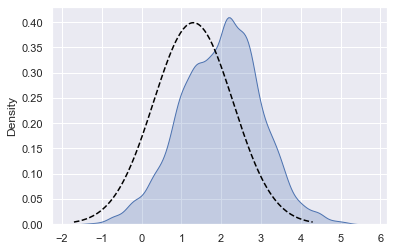

In [36]:
# Get true population distribution
pop_mu, pop_sigma = true_parameters[:2]
mus = np.linspace(pop_mu - 3 * pop_sigma, pop_mu + 3 * pop_sigma, num=200)
true_pdf = scipy.stats.norm(pop_mu, pop_sigma).pdf(mus)

# Visualise results
ax = plt.plot(
    mus, true_pdf, color='black', linestyle='--',
    label='True population distribution')
samples = data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations)).Mu.values[0]
sns.kdeplot(x=samples, fill=True)

plt.show()

More data

Using Haario adaptive covariance MCMC
Generating 1 chains.
Running in sequential mode.
Iter. Eval. Accept.   Time m:s
0     1      0          0:00.0
1     2      0.5        0:00.0
2     3      0.667      0:00.0
3     4      0.75       0:00.0
20    21     0.857      0:00.0
40    41     0.927      0:00.0
60    61     0.82       0:00.1
80    81     0.741      0:00.1
100   101    0.604      0:00.1
120   121    0.504      0:00.1
140   141    0.433      0:00.2
160   161    0.385      0:00.2
180   181    0.348      0:00.2
Initial phase completed.
200   201    0.318408   0:00.2
220   221    0.29       0:00.2
240   241    0.274      0:00.3
260   261    0.28       0:00.3
280   281    0.31       0:00.3
300   301    0.336      0:00.3
320   321    0.364486   0:00.3
340   341    0.387      0:00.4
360   361    0.388      0:00.4
380   381    0.402      0:00.4
400   401    0.416      0:00.4
420   421    0.415677   0:00.5
440   441    0.414966   0:00.5
460   461    0.419      0:00.5
480   481    0.403  

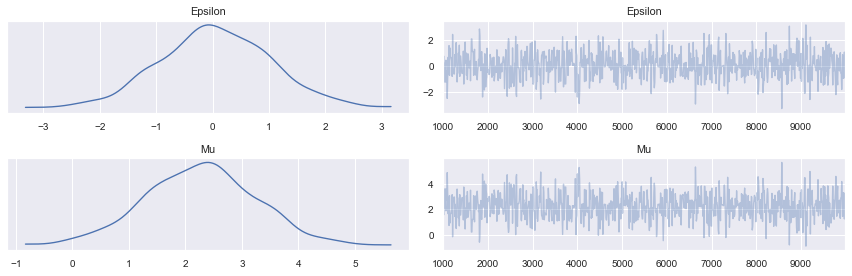

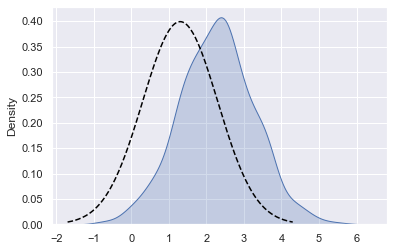

In [33]:
np.random.seed(42)
n_ids = 100000
n_samples_per_id = 1
true_parameters = [1.3, 1, 1]  # pop mean, pop std., noise
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
more_data = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    more_data[ids] = np.random.normal(
    loc=mean, scale=true_parameters[2], size=n_samples_per_id)
more_data = np.exp(np.tanh(more_data))

log_likelihood = DataCentricGaussianKDEFilterLogLikelihood(
    observations=more_data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10),
    pints.GaussianLogPrior(0, 1)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(1)
controller.set_parallel_evaluation(False)
# controller.set_sampler(pints.NoUTurnMCMC)
n_iterations = 10000
data_centric_gaussian_kde_filter_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=True)

warmup = 1000
thinning = 10
az.plot_trace(
    data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations, thinning)))
plt.tight_layout()
plt.show()

# Get true population distribution
pop_mu, pop_sigma = true_parameters[:2]
mus = np.linspace(pop_mu - 3 * pop_sigma, pop_mu + 3 * pop_sigma, num=200)
true_pdf = scipy.stats.norm(pop_mu, pop_sigma).pdf(mus)

# Visualise results
ax = plt.plot(
    mus, true_pdf, color='black', linestyle='--',
    label='True population distribution')
samples = data_centric_gaussian_kde_filter_posterior.sel(
        draw=slice(warmup, n_iterations, thinning)).Mu.values[0]
sns.kdeplot(
    x=samples, fill=True)

plt.show()

## Visualise posterior predictive Gaussian distribution (target distribution)

### Infer Gaussian distribution

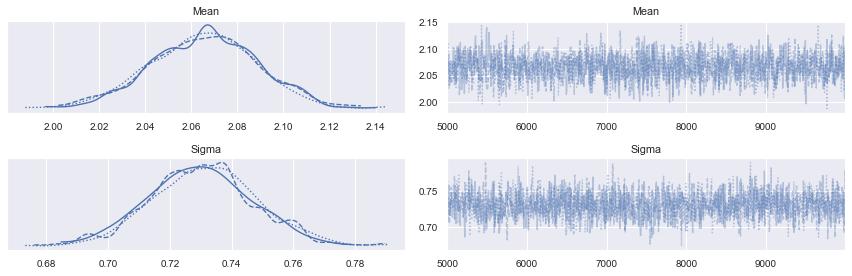

In [3]:
class GaussianLogLikelihood(chi.LogLikelihood):
    def __init__(self, observations):
        self._observations = observations.flatten()

    def __call__(self, parameters):
        # Compute population contribution
        mean, sigma = parameters
        score = np.sum(
            scipy.stats.norm(loc=mean, scale=sigma).logpdf(
                self._observations))

        return score

    def n_parameters(self):
        return 2

    def get_parameter_names(self):
        return ['Mean', 'Sigma']

    def get_id(self):
        return [None, None]


log_likelihood = GaussianLogLikelihood(observations=data)
log_prior = pints.ComposedLogPrior(*[
    pints.UniformLogPrior(-10, 10000),
    pints.UniformLogPrior(0, 1000)])
log_posterior = chi.LogPosterior(log_likelihood, log_prior)

controller = chi.SamplingController(log_posterior)
controller.set_n_runs(3)
controller.set_parallel_evaluation(True)
controller.set_transform(pints.LogTransformation(log_posterior.n_parameters()))
n_iterations = 10000
gaussian_posterior = controller.run(
    n_iterations=n_iterations, log_to_screen=False)

warmup=5000
thinning_ratio = 5
az.plot_trace(
    gaussian_posterior.sel(
        draw=slice(warmup, n_iterations, thinning_ratio)))
plt.tight_layout()

### Visualise data and Gaussian fit

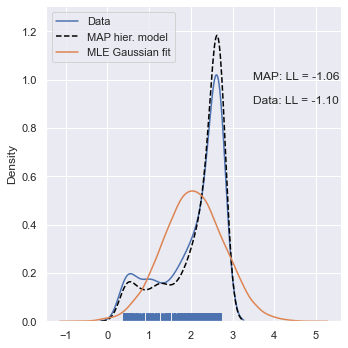

In [17]:
# Sample from Gaussian approximation
mean = 2.07
sigma = 0.73
gaussian_approx = np.random.normal(loc=mean, scale=sigma, size=10000)

# Sample from map hierarchical model
np.random.seed(42)
n_ids = 1000
n_samples_per_id = 1
true_parameters = [1.49, 1, 1]  # pop mean log, pop std. log, noise log
means = np.random.normal(
    loc=true_parameters[0], scale=true_parameters[1], size=n_ids)
temp = np.empty(shape=(n_ids, n_samples_per_id))
for ids, mean in enumerate(means):
    temp[ids] = np.random.normal(
        loc=mean, scale=true_parameters[2], size=n_samples_per_id)
map_data = np.exp(np.tanh(temp))

# Estimate cross entropy
cross_entropy_data = np.mean(scipy.stats.norm(mean, sigma).logpdf(data))
cross_entropy_map = np.mean(scipy.stats.norm(mean, sigma).logpdf(map_data))

# Visualse approximation and data
colors = sns.color_palette()
ax = sns.displot(data.flatten(), kind='kde', rug=True, label='Data')
sns.kdeplot(
    map_data.flatten(), ax=ax, color='black', linestyle='--',
    label='MAP hier. model')
sns.kdeplot(gaussian_approx, ax=ax, color=colors[1], label='MLE Gaussian fit')

# Inset cross entroy estimates
plt.text(x=3.5, y=1, s='MAP: LL = %.2f' % cross_entropy_map)
plt.text(x=3.5, y=0.9, s='Data: LL = %.2f' % cross_entropy_data)

plt.legend()
plt.show()